In [1]:
# === 0. Imports ===
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score, roc_curve, auc
import joblib
import matplotlib.pyplot as plt

In [2]:
# === 1. Load Models ===
forecast_model = tf.keras.models.load_model("best_lstm_attention_forecaster.h5")

detection_model = tf.keras.models.load_model("best_lstm_autoencoder.h5")

# === 2. Load Scalers ===
forecast_scaler = joblib.load("forecast_scaler.pkl")
detection_scaler = joblib.load("detection_scaler.pkl")

# === 3. Load Input CSV ===
file_path = "labeled_test_set_with_predictions.csv"  # full test set file

df = pd.read_csv(file_path)

In [3]:
if 'DateTime' in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)
    
original_labels = None
if 'labels' in df.columns:
    original_labels = df['labels'].copy()  # Keep original labels
    test_labels = df['labels'].values
    df = df.drop(columns=['labels'])

In [4]:
# === 4. Normalize Input for Forecast Model ===
scaled_input = forecast_scaler.transform(df.values)

scaled_forecast = pd.DataFrame(scaled_input, index=df.index, columns=df.columns)

In [5]:
# === 5. Create Chained Forecast Sequences ===
INPUT_STEPS = 32
FORECAST_STEPS = 32

def create_chained_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    i = 0
    while i + input_steps + forecast_steps <= len(data):
        input_seq = data[i:i + input_steps]
        output_seq = data[i + input_steps:i + input_steps + forecast_steps]
        X.append(input_seq)
        y.append(output_seq)
        i += forecast_steps
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_forecast_seq, y_forecast_true = create_chained_sequences(scaled_forecast, INPUT_STEPS, FORECAST_STEPS)

In [ ]:
scaled_forecast.shape

In [ ]:
X_forecast_seq.shape

In [ ]:
y_forecast_true.shape

In [29]:
# === 6. Simulate Real-Time Forecasting ===
forecast_list = []
true_windows = []

for i in range(len(X_forecast_seq)):
    input_seq = X_forecast_seq[i:i+1]
    y_true = y_forecast_true[i]
    y_pred = forecast_model.predict(input_seq, batch_size=128, verbose=1)[0]
    #y_pred[0] = y_pred[5]
    #y_pred[1] = y_pred[5]
    #y_pred[2] = y_pred[5]
    #y_pred[3] = y_pred[5]
    #y_pred[4] = y_pred[5]
    forecast_list.append(y_pred)
    true_windows.append(y_true)

1/1 [==============================] - 0s 78ms/step


In [30]:
forecast_preds = np.array(forecast_list)
y_forecast_true = np.array(true_windows)

In [31]:
# === 7. Evaluate Forecast Model (Before De-normalization) ===
y_true_flat = y_forecast_true.reshape(-1)
y_pred_flat = forecast_preds.reshape(-1)
forecast_mse = mean_squared_error(y_true_flat, y_pred_flat)
forecast_mae = mean_absolute_error(y_true_flat, y_pred_flat)

print(f"\n📈 Forecast Evaluation:")
print(f"MSE: {forecast_mse:.5f}")
print(f"MAE: {forecast_mae:.5f}")


📈 Forecast Evaluation:
MSE: 0.00533
MAE: 0.05319


In [32]:
# === 8. De-normalize Forecasts for Detection ===
forecast_preds_reshaped = forecast_preds.reshape(-1, forecast_preds.shape[2])
denorm_forecasts = forecast_scaler.inverse_transform(forecast_preds_reshaped)

denorm_forecasts_df = pd.DataFrame(denorm_forecasts, columns=df.columns)

# Fix: Create proper datetime index for forecasted sequences
forecast_start_idx = INPUT_STEPS  # Forecasts start after input window
forecast_index = df.index[forecast_start_idx:forecast_start_idx + len(denorm_forecasts_df)]
denorm_forecasts_df.index = forecast_index



In [33]:
# === Amplify variation to recover lost peaks ===
amplification_factor = 6.0# Tunable

real_std = df.std()
forecast_std = denorm_forecasts_df.std()

for col in df.columns:
    if forecast_std[col] == 0:
        continue
    scale_ratio = real_std[col] / forecast_std[col]
    
    # Limit ratio to avoid overamplifying
    adjusted_ratio = min(scale_ratio, amplification_factor)
    
    mean_val = denorm_forecasts_df[col].mean()
    denorm_forecasts_df[col] = mean_val + adjusted_ratio * (denorm_forecasts_df[col] - mean_val)

In [ ]:
# Save with proper DateTime index
denorm_forecasts_df.to_csv("LSTM_seq2seq_forecast_test_set.csv", index=True, float_format='%.10f')

In [34]:
# === 9. Load Forecasted Data (Fixed) ===
test_set_path = 'LSTM_seq2seq_forecast_test_set.csv'
df_test = pd.read_csv(test_set_path, delimiter=',')

# Fix: Properly handle DateTime column
if 'DateTime' in df_test.columns:
    df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], errors='coerce')
    df_test.set_index('DateTime', inplace=True)
elif df_test.columns[0].lower() in ['datetime', 'timestamp']:
    # If first column is unnamed datetime
    df_test.iloc[:, 0] = pd.to_datetime(df_test.iloc[:, 0], errors='coerce')
    df_test.set_index(df_test.columns[0], inplace=True)
else:
    # Remove unnamed index column if it exists
    if df_test.columns[0] == 'Unnamed: 0' or df_test.iloc[:, 0].dtype == 'int64':
        df_test.drop(df_test.columns[0], axis=1, inplace=True)

print(f"✅ Loaded forecasted test set with {len(df_test)} samples from {test_set_path}")

# Extract labels from ORIGINAL test set (not forecasted) for ground truth
if original_labels is not None:
    print("✅ Found 'labels' column in original test set.")
    # Align labels with forecasted timerange
    forecast_start_idx = INPUT_STEPS
    forecast_end_idx = forecast_start_idx + len(df_test)
    all_test_labels = original_labels.iloc[forecast_start_idx:forecast_end_idx].copy()
    df_test_features = df_test.copy()  # Use forecasted features
else:
    print("⚠️ No 'labels' column found. Will assume all samples are normal.")
    all_test_labels = pd.Series(np.zeros(len(df_test)))
    df_test_features = df_test.copy()

# === 10. Re-normalize FORECASTED data for Detection Model ===
scaled_for_detection = detection_scaler.transform(df_test_features.values)

# === 11. Create Detection Sequences ===
def create_detection_sequences(data, input_steps):
    X = []
    for i in range(0, len(data) - input_steps + 1, input_steps):
        X.append(data[i:i+input_steps])
    return np.array(X, dtype=np.float32)

X_detection = create_detection_sequences(scaled_for_detection, INPUT_STEPS)

# === 12. Simulate Real-Time Anomaly Detection ===
reconstruction_errors = []
for i in range(len(X_detection)):
    input_seq = np.expand_dims(X_detection[i], axis=0)
    y_reconstructed = detection_model.predict(input_seq, verbose=1)[0]
    mse_error = np.mean((X_detection[i] - y_reconstructed) ** 2, axis=1)
    reconstruction_errors.append(mse_error)

all_reconstruction_errors = np.concatenate(reconstruction_errors)

# Align labels with detection results
min_len = min(len(all_test_labels), len(all_reconstruction_errors))
test_labels = all_test_labels.values[:min_len]



✅ Loaded forecasted test set with 1376 samples from LSTM_seq2seq_forecast_test_set.csv
✅ Found 'labels' column in original test set.
1/1 [==============================] - 0s 76ms/step


In [35]:
original_test_labeled = None


🚨 Detection Evaluation (on Forecasted Data):
Precision: 0.00000
Recall:    0.00000
F1 Score:  0.00000


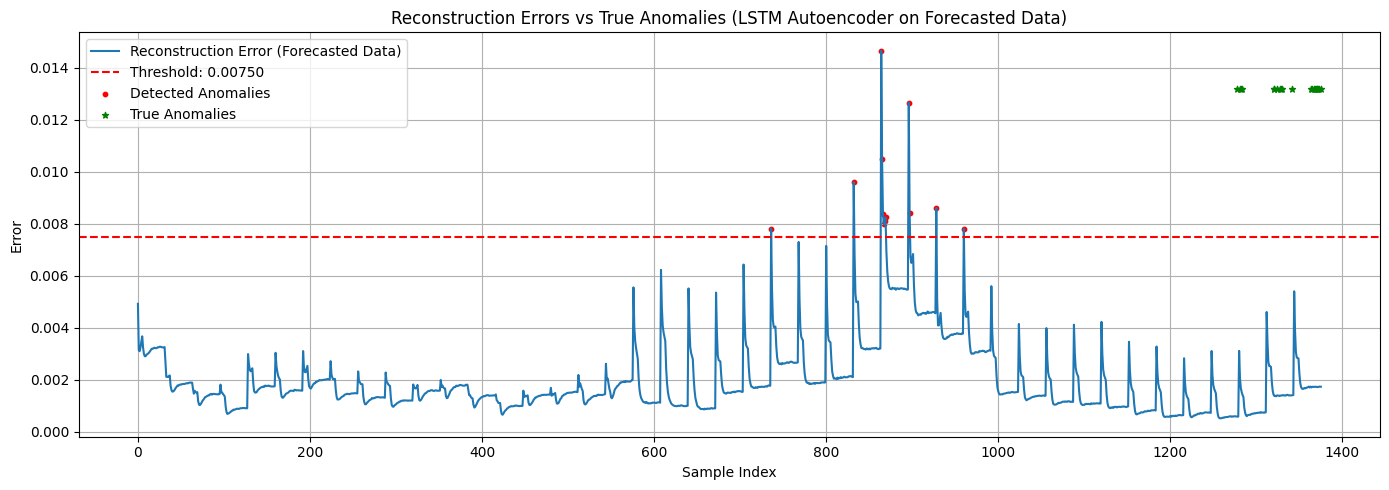

📊 Per-Sequence Metrics (Forecasted Data):
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


In [36]:
# === 13. Thresholding ===
threshold = 0.0075
all_detected = (np.array(all_reconstruction_errors) > threshold).astype(np.int32)

# === 14. Evaluation Against Ground Truth Labels ===
# Fix: Use FORECASTED data instead of original data
original_test_labeled = df_test_features.copy()[:min_len]  # Use forecasted sequences
original_test_labeled['model-labels'] = 0
original_test_labeled['model-labels'] = all_detected

# Apply domain-specific rules to FORECASTED data
attribute = "530R002D02.TI0037.MEAS"
attribute2 = "530M105D01.TIC0022.MEAS"
#lower_bound = 680
upper_bound = 728

# Step 2: Add attribute-based anomalies without removing model detections
original_test_labeled.loc[
    (original_test_labeled[attribute] > upper_bound),
    'model-labels'
] = 1
#if attribute in original_test_labeled.columns and attribute2 in original_test_labeled.columns:
#    original_test_labeled.loc[
#        (original_test_labeled[attribute2] < lower_bound) |
#        (original_test_labeled[attribute] > upper_bound),
#        'model-labels'
#    ] = 1

precision = precision_score(test_labels, original_test_labeled['model-labels'], zero_division=0)
recall = recall_score(test_labels, original_test_labeled['model-labels'], zero_division=0)
f1 = f1_score(test_labels, original_test_labeled['model-labels'], zero_division=0)

# === 15. Print Results ===
print(f"\n🚨 Detection Evaluation (on Forecasted Data):")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

# === 16. Optional Plot ===
plt.figure(figsize=(14,5))

min_plot_len = min(len(all_reconstruction_errors), len(test_labels))
plot_errors = all_reconstruction_errors[:min_plot_len]
plot_labels = test_labels[:min_plot_len]
plot_detected = all_detected[:min_plot_len]

plt.plot(plot_errors, label='Reconstruction Error (Forecasted Data)')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')

# Detected anomalies
detected_indices = np.where(plot_detected == 1)[0]
plt.scatter(detected_indices,
            plot_errors[detected_indices],
            color='red', label='Detected Anomalies', s=10)

# True anomalies
true_anomaly_indices = np.where(plot_labels == 1)[0]
if len(true_anomaly_indices) > 0:
    plt.scatter(true_anomaly_indices,
                np.ones_like(true_anomaly_indices) * np.max(plot_errors)*0.9,
                color='green', marker='*', label='True Anomalies', s=20)
else:
    print("No true anomalies found in the subset of data being visualized")

plt.title("Reconstruction Errors vs True Anomalies (LSTM Autoencoder on Forecasted Data)")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_forecasted_data.png")
plt.show()

# === 17. Per-Sequence Metrics ===
SEQUENCE_LEN = 32

# Ensure length is divisible by SEQUENCE_LEN
if len(test_labels) % SEQUENCE_LEN != 0:
    # Trim to make divisible
    trim_len = len(test_labels) - (len(test_labels) % SEQUENCE_LEN)
    test_labels = test_labels[:trim_len]
    model_labels = original_test_labeled['model-labels'].values[:trim_len]
else:
    model_labels = original_test_labeled['model-labels'].values

# Reshape into (num_sequences, sequence_length)
test_labels_seq = test_labels.reshape(-1, SEQUENCE_LEN)
model_labels_seq = model_labels.reshape(-1, SEQUENCE_LEN)

# Sequence is labeled 1 if any timestep in it is 1
y_true_seq = np.any(test_labels_seq, axis=1).astype(int)
y_pred_seq = np.any(model_labels_seq, axis=1).astype(int)

precision_seq = precision_score(y_true_seq, y_pred_seq, zero_division=0)
recall_seq = recall_score(y_true_seq, y_pred_seq, zero_division=0)
f1_seq = f1_score(y_true_seq, y_pred_seq, zero_division=0)

print("📊 Per-Sequence Metrics (Forecasted Data):")
print(f"Precision: {precision_seq:.4f}")
print(f"Recall:    {recall_seq:.4f}")
print(f"F1 Score:  {f1_seq:.4f}")

In [14]:
num_ones = np.sum(original_test_labeled['model-labels'] == 1)
print("Number of ones:", num_ones)

Number of ones: 12


In [15]:
num_ones = np.sum(all_detected == 1)
print("Number of ones:", num_ones)

Number of ones: 12


In [16]:
num_ones = np.sum(test_labels == 1)
print("Number of ones:", num_ones)

Number of ones: 21


In [17]:
num_ones = np.sum(y_pred_seq == 1)
print("Number of ones:", num_ones)

Number of ones: 6


In [18]:
num_ones = np.sum(y_true_seq == 1)
print("Number of ones:", num_ones)

Number of ones: 4


In [ ]:
all_reconstruction_errors

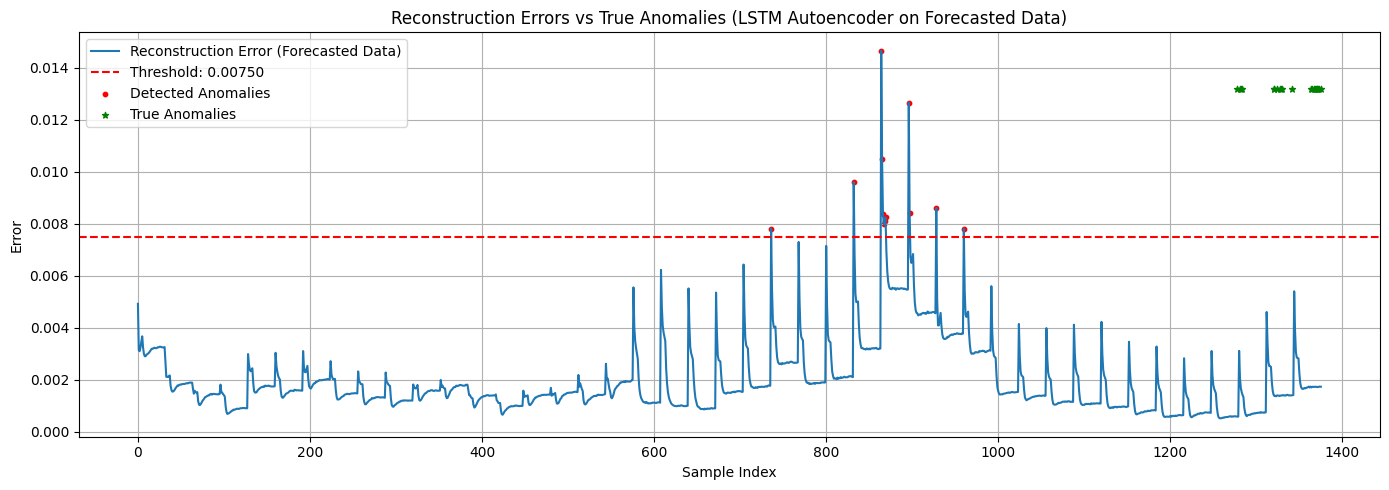

In [19]:
# === 16. Optional Plot ===
plt.figure(figsize=(14,5))

min_plot_len = min(len(all_reconstruction_errors), len(test_labels))
plot_errors = all_reconstruction_errors[:min_plot_len]
plot_labels = test_labels[:min_plot_len]
plot_detected = all_detected[:min_plot_len]

plt.plot(plot_errors, label='Reconstruction Error (Forecasted Data)')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')

# Detected anomalies
detected_indices = np.where(plot_detected == 1)[0]
plt.scatter(detected_indices,
            plot_errors[detected_indices],
            color='red', label='Detected Anomalies', s=10)

# True anomalies
true_anomaly_indices = np.where(plot_labels == 1)[0]
if len(true_anomaly_indices) > 0:
    plt.scatter(true_anomaly_indices,
                np.ones_like(true_anomaly_indices) * np.max(plot_errors)*0.9,
                color='green', marker='*', label='True Anomalies', s=20)
else:
    print("No true anomalies found in the subset of data being visualized")

plt.title("Reconstruction Errors vs True Anomalies (LSTM Autoencoder on Forecasted Data)")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_forecasted_data.png")
plt.show()


In [20]:
precision = precision_score(test_labels, original_test_labeled['model-labels'], zero_division=0)
recall = recall_score(test_labels, original_test_labeled['model-labels'], zero_division=0)
f1 = f1_score(test_labels, original_test_labeled['model-labels'], zero_division=0)


In [21]:
file_path = "labeled_test_set_with_predictions.csv"  # full test set file

final_df = pd.read_csv(file_path)

In [22]:
len(final_df["labels"])

1440

In [23]:
original_labels.shape

(1440,)

In [24]:
len(original_test_labeled['model-labels'])

1376

In [25]:
all_test_labels.shape

(1376,)

In [26]:
# Keep only the aligned portion of final_df
start_idx = INPUT_STEPS
end_idx = start_idx + len(original_test_labeled)

final_df = final_df.iloc[start_idx:end_idx].copy()

# Now insert the aligned labels
final_df['labels'] = original_test_labeled['model-labels'].values

# Check length
print(len(final_df))  # Should print 1408


1376


In [27]:
len(final_df['labels'])

1376

In [28]:
print("v)

SyntaxError: EOL while scanning string literal (2037156129.py, line 1)

In [ ]:
# Or: manually edit specific indexes
final_df.loc[1350:1399, 'labels'] = 1  # Force label = 1 for rows 100 to 105

In [ ]:
# Save to new file
final_df.to_csv("final_df_with_updated_labels.csv", index=False)